<a href="https://colab.research.google.com/github/Sunkist2lee/Sunkist2lee/blob/main/%EC%9D%B8%EA%B3%B5%EC%A7%80%EB%8A%A5(%EB%94%A5%EB%9F%AC%EB%8B%9D)%EA%B0%9C%EB%A1%A0_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CIFAR10 Dataset Classifier Model by CNN (Convolution Neural Network)**

1. Module Import & Define Hyper-parameters

In [ ]:
import torch

In [ ]:
## Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
batch_size = 16
learning_rate = 0.001
num_epochs = 10

2. Load Data

In [ ]:
import torchvision
import torchvision.transforms as transforms

In [ ]:
## 데이터 텐서 변환 및 정규화
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

## Load Data
train_data = torchvision.datasets.CIFAR10(root='./datasets',
                                        train=True,
                                        transform=transforms.ToTensor(),
                                        download=True)

test_data = torchvision.datasets.CIFAR10(root='./datasets',
                                       train=False,
                                       transform=transforms.ToTensor())

Files already downloaded and verified


3. Define Dataloader

In [ ]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                        shuffle=False, num_workers=2)

In [ ]:
## CIFAR10 DATASET 클래스 정의
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')


4. Check Images

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

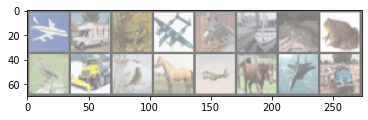

    plane        truck         frog        plane   


In [ ]:
def imshow(img):
  ## Unnormalized  
  img = img / 2 + 0.5 
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0))) ## 형식 맞추기 
  plt.show()

# 학습용 이미지 뽑기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Show Images 
imshow(torchvision.utils.make_grid(images))

# 이미지별 클래스 Batch_size 개수만큼
print(' '.join('    %5s   ' % classes[labels[j]] for j in range(4)))

5. CNN 모델 구현

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torchsummary as summary ## layer 별 output shape 출력을 위해

class Net(nn.Module):
  def __init__(self, num_classes = 10):
      super(Net, self).__init__()

      #input = 3, 6 channel out, 5 * 5 kernal
      self.conv1 = nn.Sequential(
          nn.Conv2d(3, 6, 5, padding = 1),
          nn.BatchNorm2d(6),
          nn.ReLU(),
          nn.MaxPool2d((2,2),stride=2)
      )

      #input = 6. 16 channel out, 3 * 3 kernal
      self.conv2 = nn.Sequential(
          nn.Conv2d(6, 16, 3, padding = 1),
          nn.BatchNorm2d(16),
          nn.ReLU(),
          nn.MaxPool2d((2,2),stride=2)
      )

      #input = 16. 32 channel out, 3 * 3 kernal
      self.conv3 = nn.Sequential(
          nn.Conv2d(16, 32, 3, padding = 1), 
          nn.BatchNorm2d(32), 
          nn.ReLU(),
          nn.MaxPool2d((2,2),stride=2)
      )

      self.fc1 = nn.Linear(288, 120)
      self.fc2 = nn.Linear(120, 84)
      self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
      x = self.conv1(x)
      x = self.conv2(x)
      x = self.conv3(x)
      x = x.reshape(x.size(0),-1)
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return x

model = Net(10).to(device) ## 인스턴스 

- summary를 통한 Layer 별 Output Shape 확인

In [ ]:
## Network Form 확인
print(model)

## check the number of parameters
print('{:=^60}'.format("="))
print('{:^60}'.format("model summary"))
print('{:=^60}'.format("="))
for param_tensor in model.state_dict():
  print('%-30s'%param_tensor, '{:^30}'.format(str(model.state_dict()[param_tensor].size())))
print('{:=^60}'.format("="))

Net(
  (conv1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=288, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84,

6. Loss Function & Optimizer Setting

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

7. Train / Test

In [ ]:
total_step = len(trainloader)
loss_list = []

# Train
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(trainloader,0):
    # Assign Tensors to Configured Device
    images = images.to(device)
    labels = labels.to(device)

    # Forward Propagation
    outputs = model(images)

    # Get Loss, Compute Gradient, Update Parameters
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Append loss to plot graph
    loss_list.append(loss)

    # Print Loss for Tracking Training
    if (i+1) % 2000 == 0:
      acc = 0
      test_image, test_label = next(iter(testloader))
      _, test_predicted = torch.max(model(test_image.to(device)).data, 1)

      for (pred, ans) in zip(test_predicted, test_label):
        if pred == ans:
          acc += 1
      acc = acc / len(test_predicted)

      print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.1f}%'.format(epoch+1,num_epochs,loss.item(), acc*100))
      print('Testing data: [Predicted: {} / Real: {}]'.format(test_predicted, test_label))

  if epoch+1 == num_epochs:
    torch.save(model.state_dict(), 'model.pth')
  else:
    torch.save(model.state_dict(), 'model-{:02d}_epochs.pth'.format(epoch+1))

Epoch [1/10], Loss: 1.8633, Accuracy: 81.2%
Testing data: [Predicted: tensor([3, 8, 8, 0, 6, 6, 9, 6, 3, 1, 0, 9, 6, 7, 9, 0]) / Real: tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8])]
Epoch [2/10], Loss: 1.2242, Accuracy: 62.5%
Testing data: [Predicted: tensor([3, 8, 8, 0, 2, 6, 5, 6, 5, 1, 0, 9, 2, 7, 1, 4]) / Real: tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8])]
Epoch [3/10], Loss: 1.3936, Accuracy: 75.0%
Testing data: [Predicted: tensor([3, 8, 8, 0, 4, 6, 1, 2, 3, 1, 0, 9, 6, 7, 9, 0]) / Real: tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8])]
Epoch [4/10], Loss: 1.2093, Accuracy: 87.5%
Testing data: [Predicted: tensor([3, 8, 8, 0, 6, 6, 1, 2, 3, 1, 0, 9, 6, 7, 9, 8]) / Real: tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8])]
Epoch [5/10], Loss: 0.8430, Accuracy: 75.0%
Testing data: [Predicted: tensor([3, 8, 8, 0, 4, 6, 1, 2, 3, 1, 5, 9, 4, 7, 9, 8]) / Real: tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8])]
Epoch [6/10], Loss: 1.3874, Accurac

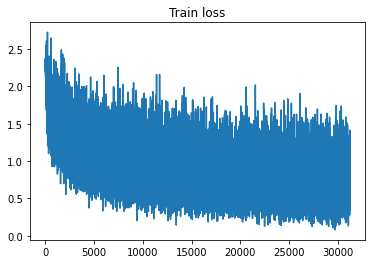

In [ ]:
plt.plot(loss_list)
plt.title("Train loss")
plt.show()